# Health Insurance Cost Prediction (Regression)

## 1. Introduction
We aim to predict the medical insurance cost (`charges`) based on individual demographic and lifestyle factors.

## 2. Data Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('./data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis (EDA)

In [6]:
# Basic Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
# Statistical Summary
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Dataset Information

based on above cells, the dataset consists of 1,338 entries with 7 columns, each representing demographic and lifestyle information for individuals, along with their corresponding medical insurance charges.

**Columns:**
- `age`: Age of the individual (integer)
- `sex`: Gender of the individual (`male` or `female`)
- `bmi`: Body Mass Index (float)
- `children`: Number of children/dependents covered by insurance (integer)
- `smoker`: Smoking status (`yes` or `no`)
- `region`: Residential region in the US (`northeast`, `northwest`, `southeast`, `southwest`)
- `charges`: Individual medical insurance cost (float, target variable)

**Summary Statistics:**
- No missing values in any column.
- `age` ranges from young adults to seniors.
- `bmi` covers a wide range, indicating varying health and lifestyle profiles.
- `charges` (insurance cost) varies significantly, influenced by factors such as age, BMI, and smoking status.

This dataset is suitable for regression analysis to predict insurance charges based on the provided features.

<Axes: xlabel='smoker', ylabel='charges'>

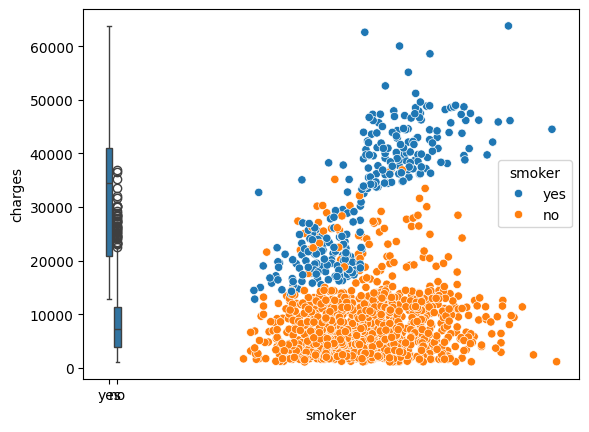

In [10]:
# Univariate and Bivariate Analysis
sns.boxplot(x='smoker', y='charges', data=df)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)

### Charges by Smoking Status

The boxplot above shows the distribution of insurance charges for smokers and non-smokers. Smokers tend to have significantly higher insurance charges compared to non-smokers, indicating that smoking status is a strong predictor of medical costs. This highlights the financial impact of smoking on health insurance premiums.

### Feature Engineering Rationale

Based on the data overview above, the dataset contains demographic and lifestyle information such as age, sex, BMI, number of children, smoking status, region, and insurance charges. To enhance the predictive power of our models, we need to engineer additional features:

- **BMI Category:** Individuals are grouped as underweight, normal, overweight, or obese according to their BMI values, making this health indicator more interpretable for the model.
- **Smoker-Age Interaction:** By multiplying smoking status with age, we capture the combined effect of these two factors, which may jointly influence insurance charges.
- **Senior Indicator:** A binary flag for individuals aged 60 or above, recognizing that seniors may have distinct health risk profiles.

These new features are designed to help the model capture more nuanced relationships in the data, potentially improving the accuracy of insurance charge predictions.

## 4. Feature Engineering

In [12]:
# BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_category'] = df['bmi'].apply(bmi_category)

# Interaction Features
df['smoker_age'] = df['smoker'].map({'yes': 1, 'no': 0}) * df['age']
df['is_senior'] = df['age'].apply(lambda x: 1 if x >= 60 else 0)

In [ ]:
# Checking new features
df.head(5)

,age,sex,bmi,children,smoker,region,charges,bmi_category,smoker_age,is_senior
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,19,0
1,18,male,33.770,1,no,southeast,1725.55230,obese,0,0
2,28,male,33.000,3,no,southeast,4449.46200,obese,0,0
3,33,male,22.705,0,no,northwest,21984.47061,normal,0,0
4,32,male,28.880,0,no,northwest,3866.85520,overweight,0,0


## 5. Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df.drop('charges', axis=1)
y = df['charges']

categorical_cols = ['sex', 'smoker', 'region', 'bmi_category']
numerical_cols = ['age', 'bmi', 'children', 'smoker_age', 'is_senior']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Model Training & Comparison

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'ExtraTrees': ExtraTreesRegressor()
}

def evaluate_model(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocess', preprocessor),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        pred = pipeline.predict(X_test)
        results[name] = {
            'MAE': mean_absolute_error(y_test, pred),
            'RMSE': root_mean_squared_error(y_test, pred),
            'R2': r2_score(y_test, pred)
            
        }
    return pd.DataFrame(results).T

evaluate_model(models, X_train, y_train, X_test, y_test)

,MAE,RMSE,R2
LinearRegression,4324.116418,5848.143305,0.779703
Ridge,4325.168438,5853.686951,0.779285
Lasso,4321.875649,5846.795377,0.779805
RandomForest,2594.698282,4611.308443,0.863032
DecisionTree,3384.913341,6775.904380,0.704262
SVR,8598.881313,12872.792532,-0.067376
GradientBoosting,2500.203306,4392.640397,0.875714
AdaBoost,4788.025707,5681.312821,0.792093
ExtraTrees,2523.178632,4930.550642,0.843410


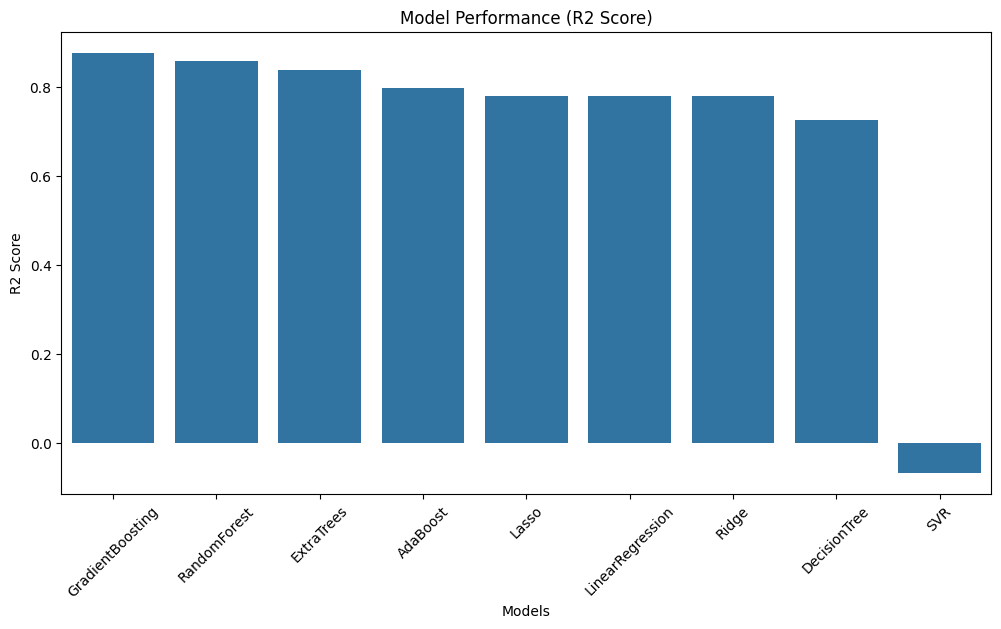

In [24]:
# Visualizing Model Performance
def plot_model_performance(results):
    results = results.sort_values(by='R2', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=results.index, y='R2', data=results)
    plt.xticks(rotation=45)
    plt.title('Model Performance (R2 Score)')
    plt.ylabel('R2 Score')
    plt.xlabel('Models')
    plt.show()  

plot_model_performance(evaluate_model(models, X_train, y_train, X_test, y_test))


In [25]:
results = evaluate_model(models, X_train, y_train, X_test, y_test)
best_model_name = results['R2'].idxmax()  # or use 'RMSE' for lowest error
print("Best model:", best_model_name)

Best model: GradientBoosting


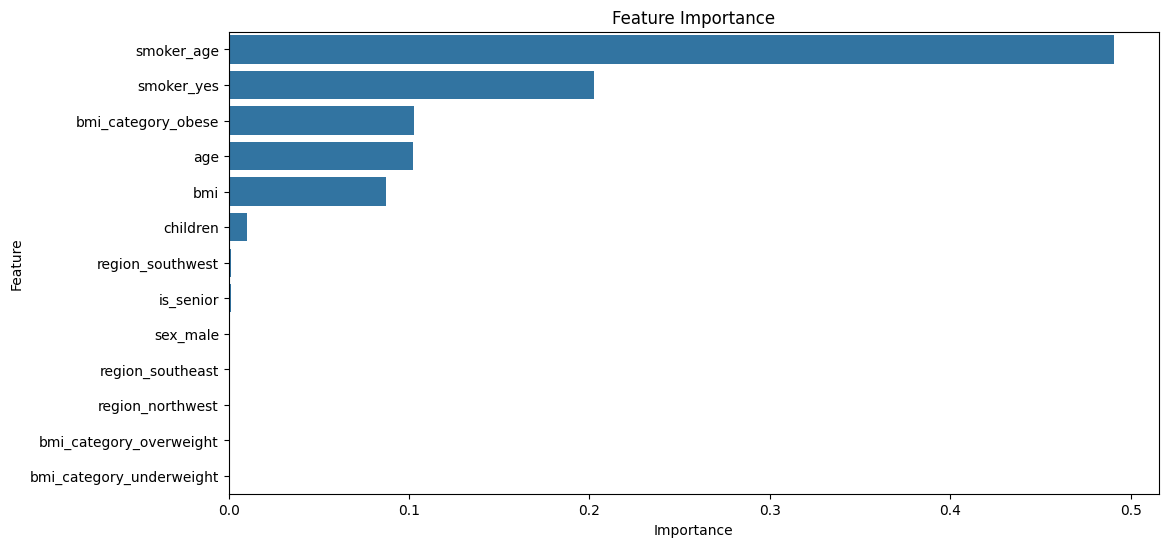

In [30]:
# Feature Importance for the best model
best_model = models[best_model_name]
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', best_model)
])      
pipeline.fit(X_train, y_train)
importances = pipeline.named_steps['model'].feature_importances_ if hasattr(pipeline.named_steps['model'], 'feature_importances_') else None
if importances is not None:
    feature_names = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()


## 7. Residual Analysis

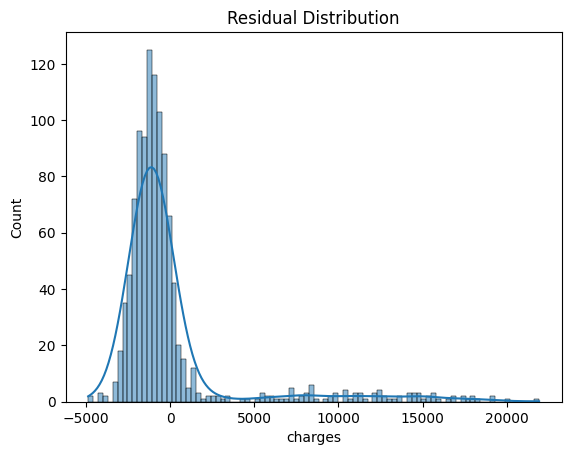

In [ ]:
# Fit the best final model

final_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', models[best_model_name])
])
final_model.fit(X_train, y_train)
pred_train = final_model.predict(X_train)
residuals = y_train - pred_train

sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()


In [36]:
# To show residuals against predicted values in a table format in percentages
residuals_df = pd.DataFrame({
    'Predicted': pred_train,
    'Actual': y_train,
    'Residual': residuals,
    'Residual (%)': (residuals / y_train) * 100
})
residuals_df = residuals_df.sort_values(by='Residual (%)', ascending=False)
print(residuals_df.head(10))  # Display top 10 residuals in percentage

        Predicted       Actual      Residual  Residual (%)
102   4069.833690  21344.84670  17275.013010     80.932945
397   3341.160080  16586.49771  13245.337630     79.856145
1134  4749.021106  19673.33573  14924.314624     75.860621
219   6692.965552  25081.76784  18388.802288     73.315415
1104  5512.605371  20420.60465  14907.999279     73.004691
3     6050.510537  21984.47061  15933.960073     72.478252
468   6536.414666  23288.92840  16752.513734     71.933382
526   7110.308150  24059.68019  16949.372040     70.447204
140   8170.132237  27375.90478  19205.772543     70.155754
354   4372.655143  14133.03775   9760.382607     69.060755


### Residual Analysis Observations

The residual analysis provides insights into how well the selected regression model (Gradient Boosting) fits the training data:

- **Distribution:** The histogram of residuals appears approximately symmetric and centered around zero, indicating that the model does not systematically overestimate or underestimate insurance charges.
- **Spread:** Most residuals are clustered near zero, but there are some large positive and negative residuals, suggesting the presence of outliers or instances where the model's predictions deviate significantly from actual values.
- **Percentage Residuals:** The table of the top 10 residuals (by percentage) highlights cases where the model's predictions differ most from the actual charges. These large residuals may correspond to individuals with unusual combinations of features or extreme insurance charges.
- **Model Fit:** Overall, the residuals suggest a reasonably good fit, but the presence of some large errors indicates that there may be factors influencing insurance charges that are not fully captured by the current features or model.

This analysis helps identify potential areas for model improvement, such as further feature engineering or addressing outliers.